<a href="https://colab.research.google.com/github/yusukennn/pytorch_prac/blob/main/lstm_price.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [57]:
# 必要なパッケージのインストール
!pip3 install torch==1.6.0+cu101
!pip3 install torchvision==0.7.0+cu101
!pip3 install numpy==1.18.5
!pip3 install matplotlib==3.2.2
!pip3 install scikit-learn==0.23.1
!pip3 install seaborn==0.11.0

ERROR: Could not find a version that satisfies the requirement torch==1.6.0+cu101 (from versions: 0.1.2, 0.1.2.post1, 0.1.2.post2, 0.3.1, 0.4.0, 0.4.1, 1.0.0, 1.0.1, 1.0.1.post2, 1.1.0, 1.2.0, 1.3.0, 1.3.1, 1.4.0, 1.5.0, 1.5.1, 1.6.0, 1.7.0, 1.7.1)
ERROR: No matching distribution found for torch==1.6.0+cu101
ERROR: Could not find a version that satisfies the requirement torchvision==0.7.0+cu101 (from versions: 0.1.6, 0.1.7, 0.1.8, 0.1.9, 0.2.0, 0.2.1, 0.2.2, 0.2.2.post2, 0.2.2.post3, 0.3.0, 0.4.0, 0.4.1, 0.4.2, 0.5.0, 0.6.0, 0.6.1, 0.7.0, 0.8.0, 0.8.1, 0.8.2)
ERROR: No matching distribution found for torchvision==0.7.0+cu101


In [58]:
# 必要なパッケージのインストール
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
import torch
from torch.utils.data import TensorDataset, DataLoader
from torch import nn
import torch.nn.functional as F
from torch import optim

In [59]:
from google.colab import files

In [60]:
dataset = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/pytorch_begin/prices.csv')
print(dataset.head())

                  date symbol        open  ...         low        high     volume
0  2016-01-05 00:00:00   WLTW  123.430000  ...  122.309998  126.250000  2163600.0
1  2016-01-06 00:00:00   WLTW  125.239998  ...  119.940002  125.540001  2386400.0
2  2016-01-07 00:00:00   WLTW  116.379997  ...  114.930000  119.739998  2489500.0
3  2016-01-08 00:00:00   WLTW  115.480003  ...  113.500000  117.440002  2006300.0
4  2016-01-11 00:00:00   WLTW  117.010002  ...  114.089996  117.330002  1408600.0

[5 rows x 7 columns]


In [61]:
# 銘柄(symbol)の確認
symbols = list(set(dataset.symbol))
len("The number of symbols: {}".format(symbols))
print(symbols[:10]) # 10件の銘柄を表示

['ULTA', 'PVH', 'HOLX', 'SPG', 'DTE', 'HPQ', 'SLG', 'TDC', 'BXP', 'NFX']


In [62]:
# ヤフーのみを抽出
dataset = dataset[dataset['symbol'] == 'YHOO']
print(dataset.head())

            date symbol       open      close        low       high      volume
713   2010-01-04   YHOO  16.940001  17.100000  16.879999  17.200001  16587400.0
1181  2010-01-05   YHOO  17.219999  17.230000  17.000000  17.230000  11718100.0
1649  2010-01-06   YHOO  17.170000  17.170000  17.070000  17.299999  16422000.0
2117  2010-01-07   YHOO  16.809999  16.700001  16.570000  16.900000  31816300.0
2585  2010-01-08   YHOO  16.680000  16.700001  16.620001  16.760000  15470000.0


In [63]:
# 始値(open)、安値(low)、高値(high)、出来高(volume)を消して、終値(close)のみを残す
dataset = dataset.drop(['open', 'low', 'high', 'volume'], axis=1)
print(dataset.head())

            date symbol      close
713   2010-01-04   YHOO  17.100000
1181  2010-01-05   YHOO  17.230000
1649  2010-01-06   YHOO  17.170000
2117  2010-01-07   YHOO  16.700001
2585  2010-01-08   YHOO  16.700001


In [64]:
# 終値の25日移動平均（25MA）を算出
dataset['25MA'] = dataset['close'].rolling(window=25, min_periods=0).mean()
print(dataset.head())

            date symbol      close       25MA
713   2010-01-04   YHOO  17.100000  17.100000
1181  2010-01-05   YHOO  17.230000  17.165000
1649  2010-01-06   YHOO  17.170000  17.166667
2117  2010-01-07   YHOO  16.700001  17.050000
2585  2010-01-08   YHOO  16.700001  16.980000


In [65]:
# 日付(date)をobject型からdatetime64型に変換
print(dataset['date'].dtype)  # 変換前
dataset['date'] = pd.to_datetime(dataset['date'])
print(dataset['date'].dtype) #変換後

object
datetime64[ns]


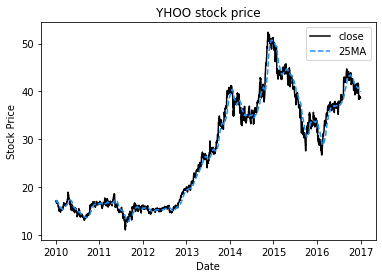

In [66]:
# 終値と25日移動平均を図
plt.figure()
plt.title("YHOO stock price")
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.plot(dataset['date'], dataset['close'], color='black',
         linestyle='-', label='close')
plt.plot(dataset['date'], dataset['25MA'], color='dodgerblue',
         linestyle='--', label='25MA')
plt.legend() # 凡例
plt.savefig('5-2_stock_price.png')
plt.show()

### 標準化
入力する25日移動平均を平均値が０，標準偏差が１となるように標準化する．
→学習時の損失収束を早め，効率的に学習することができる．



In [67]:
ma = dataset['25MA'].values.reshape(-1, 1)
scaler = StandardScaler()
ma_std = scaler.fit_transform(ma)
print("ma: {}".format(ma))
print("ma_std: {}".format(ma_std))

ma: [[17.1       ]
 [17.165     ]
 [17.16666667]
 ...
 [40.1083998 ]
 [40.01359984]
 [39.9219998 ]]
ma_std: [[-0.88504099]
 [-0.87931043]
 [-0.8791635 ]
 ...
 [ 1.14343482]
 [ 1.13507703]
 [ 1.12700135]]


In [68]:
data = [] # 入力データ(過去25日分の移動平均)
label = [] # 出力データ(1日後の移動平均)
for i in range(len(ma_std) - 25):
  data.append(ma_std[i:i + 25])
  label.append(ma_std[i + 25])
# ndarrayに変換
data = np.array(data)
label = np.array(label)
print("data size: {}".format(data.shape))
print("label size: {}".format(label.shape))

data size: (1737, 25, 1)
label size: (1737, 1)


In [69]:
# 訓練データとテストデータのサイズを決定
test_len = int(252)
train_len = int(data.shape[0] - test_len)
# 訓練データの準備
train_data = data[:train_len]
train_label = label[:train_len]
# テストデータの準備
test_data = data[train_len:]
test_label = label[train_len:]
# データの形状を確認
print("train_data size: {}".format(train_data.shape))
print("teest_data size: {}".format(test_data.shape))
print("train_label size: {}".format(train_label.shape))
print("test_label size: {}".format(test_label.shape))

train_data size: (1485, 25, 1)
teest_data size: (252, 25, 1)
train_label size: (1485, 1)
test_label size: (252, 1)


In [70]:
# ndarrayをPyTorchのTensorに変換
train_x = torch.Tensor(train_data)
test_x = torch.Tensor(test_data)
train_y = torch.Tensor(train_label)
test_y = torch.Tensor(test_label)

In [71]:
# 特徴量とラベルを結合したデータセット
train_dataset = TensorDataset(train_x, train_y)
test_dataset = TensorDataset(test_x, test_y)

In [72]:
# ミニバッチサイズを指定したdataloader
train_batch = DataLoader(
    dataset=train_dataset, #データセット指定
    batch_size=128, # バッチサイズの指定
    shuffle=True, # シャッフルするか
    num_workers=2 # コア数
)
test_batch = DataLoader(
    dataset=test_dataset,
    batch_size=128,
    shuffle=True,
    num_workers=2
)
# ミニバッチデータセット確認
for data, label in train_batch:
  print("batch data size: {}".format(data.size())) #　バッチ入力データサイズ
  print("batch label size: {}".format(label.size())) # バッチのラベルサイズ
  break


batch data size: torch.Size([128, 25, 1])
batch label size: torch.Size([128, 1])


# ニューラルネットワークの定義

In [73]:
class Net(nn.Module):
  def __init__(self, D_in, H, D_out):
    super(Net, self).__init__()
    self.lstm = nn.LSTM(D_in, H, batch_first=True,
                        num_layers=1)
    self.linear = nn.Linear(H, D_out)

  def forward(self, x):
    output, (hidden, cell) = self.lstm(x)
    output = self.linear(output[:, -1, :]) # 最後のステップだけ入力
    return output

In [74]:
# ハイパーパラメータ
D_in = 1
H = 200
D_out = 1
epoch = 100

In [75]:
# ネットワークのロード
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
net = Net(D_in, H, D_out).to(device)
# デバイス確認
print("Device: {}".format(device))

Device: cuda


In [76]:
# 損失関数の定義
criterion = nn.MSELoss()  #　損失関数(平均二乗誤差:MSE)

# 最適化関数
optimizer = optim.Adam(net.parameters())

# 学習

In [77]:
# 損失を保存するリストを作成
train_loss_list = [] # 学習損失
test_loss_list = [] # 評価損失

# 学習(エポック)の実行
for i in range(epoch):
  # エポックの進行状況を表示
  print('-----------------------------')
  print("Epoch: {}/{}".format(i+1, epoch))

  # 損失の初期化
  train_loss = 0
  test_loss = 0

  #------------学習パート----------#
  #ニューラルネットワークを学習モードに設定
  net.train()
  # ミニバッチごとにデータをロードし学習
  for data, label in train_batch:
    # GPUにTensorを転送
    data = data.to(device)
    label = label.to(device)

    optimizer.zero_grad() # 勾配を初期化
    y_pred = net(data) # データを入力して予測値を計算(順伝播)
    loss = criterion(y_pred, label) # 損失(誤差)を計算
    loss.backward() # 勾配の計算(逆伝播)
    optimizer.step() # パラメータの更新
    train_loss += loss.item() # ミニバッチごとの損失を蓄積

  # ミニバッチの平均の損失を計算
  batch_train_loss = train_loss / len(train_batch)
  #---------学習パートはここまで-----------#

  #----------評価パート-------------#
  net.eval()  # ニューラルネットワークを評価モードに設定
  # 評価時の計算で自動微分きのうをオフにする
  with torch.no_grad():
    for data, label in test_batch:
      data = data.to(device)
      label = label.to(device)
      y_pred = net(data) # データを入力して予測値を計算(順伝播)
      loss = criterion(y_pred, label) # 誤差を計算
      test_loss += loss.item() # ミニバッチごとの損失を蓄積

  # ミニバッチの平均の損失を計算
  batch_test_loss = test_loss / len(test_batch)
  # -----------評価パートはここまで-------------#

  # エポックごとに損失を表示
  print("Train_Loss: {:.2E} Test_Loss: {:.2E}".format(
        batch_train_loss, batch_test_loss))
  # 損失をリスト化して保存
  train_loss_list.append(batch_train_loss)
  test_loss_list.append(batch_test_loss)

-----------------------------
Epoch: 1/100
Train_Loss: 6.44E-01 Test_Loss: 1.95E-01
-----------------------------
Epoch: 2/100
Train_Loss: 7.78E-02 Test_Loss: 1.48E-02
-----------------------------
Epoch: 3/100
Train_Loss: 2.25E-02 Test_Loss: 6.66E-03
-----------------------------
Epoch: 4/100
Train_Loss: 1.42E-02 Test_Loss: 8.06E-03
-----------------------------
Epoch: 5/100
Train_Loss: 8.69E-03 Test_Loss: 6.06E-03
-----------------------------
Epoch: 6/100
Train_Loss: 6.17E-03 Test_Loss: 3.74E-03
-----------------------------
Epoch: 7/100
Train_Loss: 4.57E-03 Test_Loss: 3.71E-03
-----------------------------
Epoch: 8/100
Train_Loss: 3.64E-03 Test_Loss: 3.18E-03
-----------------------------
Epoch: 9/100
Train_Loss: 2.74E-03 Test_Loss: 2.42E-03
-----------------------------
Epoch: 10/100
Train_Loss: 2.22E-03 Test_Loss: 2.08E-03
-----------------------------
Epoch: 11/100
Train_Loss: 1.87E-03 Test_Loss: 1.93E-03
-----------------------------
Epoch: 12/100
Train_Loss: 1.62E-03 Test_Loss

# 結果の可視化

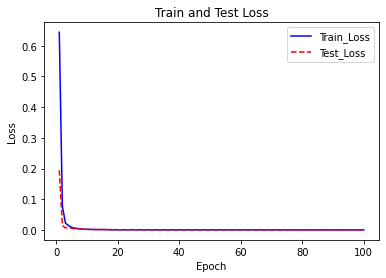

In [78]:
# 損失
plt.figure()
plt.title('Train and Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(range(1, epoch+1), train_loss_list, color='blue',
         linestyle='-', label='Train_Loss')
plt.plot(range(1, epoch+1), test_loss_list, color='red',
         linestyle='--', label='Test_Loss')
plt.legend()  # 凡例
plt.show()  # 表示

In [79]:
# ニューラルネットワークを評価モードに設定
net.eval()
#　推定時の自動微分をオフ
with torch.no_grad():
  # 初期化
  pred_ma = []
  true_ma = []
  for data, label in test_batch:
    # GPUにTensorを転送
    data = data.to(device)
    label = label.to(device)
    # データを入力して予測値を計算(順伝播)
    y_pred = net(data)
    pred_ma.append(y_pred.view(-1).tolist()) # Tensorを1次元listに変換
    true_ma.append(label.view(-1).tolist())

In [80]:
# Tensorを数値データを取り出す
pred_ma = [elem for lst in pred_ma for elem in lst] # listを1次元配列に
true_ma = [elem for lst in true_ma for elem in lst]

# 標準化を解除して元の株価に変換
pred_ma = scaler.inverse_transform(pred_ma)
true_ma = scaler.inverse_transform(true_ma)

In [81]:
# MAEの計算
mae = mean_absolute_error(true_ma, pred_ma)
print("MAE: {:.3f}".format(mae))

MAE: 0.170


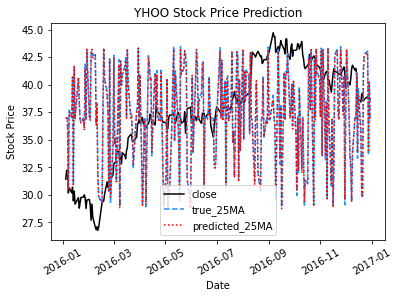

In [83]:
# 終値と25日移動平均を図示
date = dataset['date'][-1*test_len:]  # テストデータの日付
test_close = dataset['close'][-1*test_len:].values.reshape(-1)  # テストデータの終値
plt.figure()
plt.title('YHOO Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.plot(date, test_close, color='black',
         linestyle='-', label='close')
plt.plot(date, true_ma, color='dodgerblue',
         linestyle='--', label='true_25MA')
plt.plot(date, pred_ma, color='red',
         linestyle=':', label='predicted_25MA')
plt.legend()  # 凡例
plt.xticks(rotation=30)  # x軸ラベルを30度回転して表示
plt.show()